In [ ]:
pip install transformers pandas scikit-learn matplotlib sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd


# Initialize the models
model_name = "bert-base-nli-mean-tokens"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = SentenceTransformer(model_name)
mlm_pipeline = pipeline('fill-mask', model="bert-base-uncased", tokenizer=tokenizer)

def calculate_similarity_drop(sentence):
    # Tokenize and check length
    tokens = tokenizer.tokenize(sentence)
    if len(tokens) > tokenizer.model_max_length:
        tokens = tokens[:tokenizer.model_max_length]

    # Original sentence embedding
    original_embedding = model.encode(sentence, convert_to_tensor=True).cpu().numpy()

    max_drop = 0
    for i, _ in enumerate(tokens):
        # Skip special tokens
        if tokens[i] in [tokenizer.sep_token, tokenizer.cls_token]:
            continue

        # Mask one token at a time
        masked_tokens = tokens.copy()
        masked_tokens[i] = tokenizer.mask_token
        masked_sentence = tokenizer.convert_tokens_to_string(masked_tokens)

        # Generate text with MLM
        try:
            filled_sentence = mlm_pipeline(masked_sentence)[0]['sequence']
        except Exception as e:
            print(e)
            continue

        # Calculate similarity
        filled_embedding = model.encode(filled_sentence, convert_to_tensor=True).cpu().numpy()
        similarity = cosine_similarity([original_embedding], [filled_embedding])[0][0]
        drop = 1 - similarity
        max_drop = max(max_drop, drop)

    return max_drop


# Apply the function to your DataFrame
results = []
for index, row in df.iterrows():
    sentence = row['source_article']
    if pd.isna(sentence) or sentence.strip() == "":
        continue
    drop = calculate_similarity_drop(sentence)
    results.append({'fallacy': row['updated_label'], 'similarity_drop': drop})

results_df = pd.DataFrame(results)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


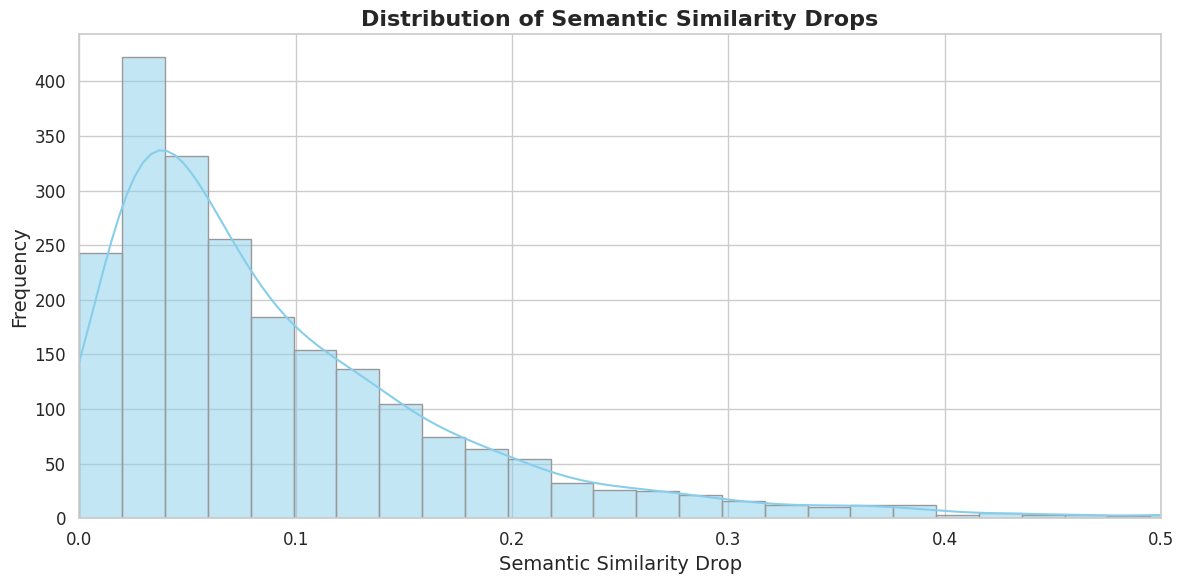

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="pastel")

# Enhanced Histogram for Semantic Similarity Drops
plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='similarity_drop', kde=True, color="skyblue", binwidth=0.02, edgecolor='.6')
plt.title('Distribution of Semantic Similarity Drops', fontsize=16, fontweight='bold')
plt.xlabel('Semantic Similarity Drop', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 0.5)  # Focusing on a specific range for more detail
plt.tight_layout()
plt.show()


<ipython-input-16-9a98d826bc78>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='fallacy', y='similarity_drop', palette="coolwarm")


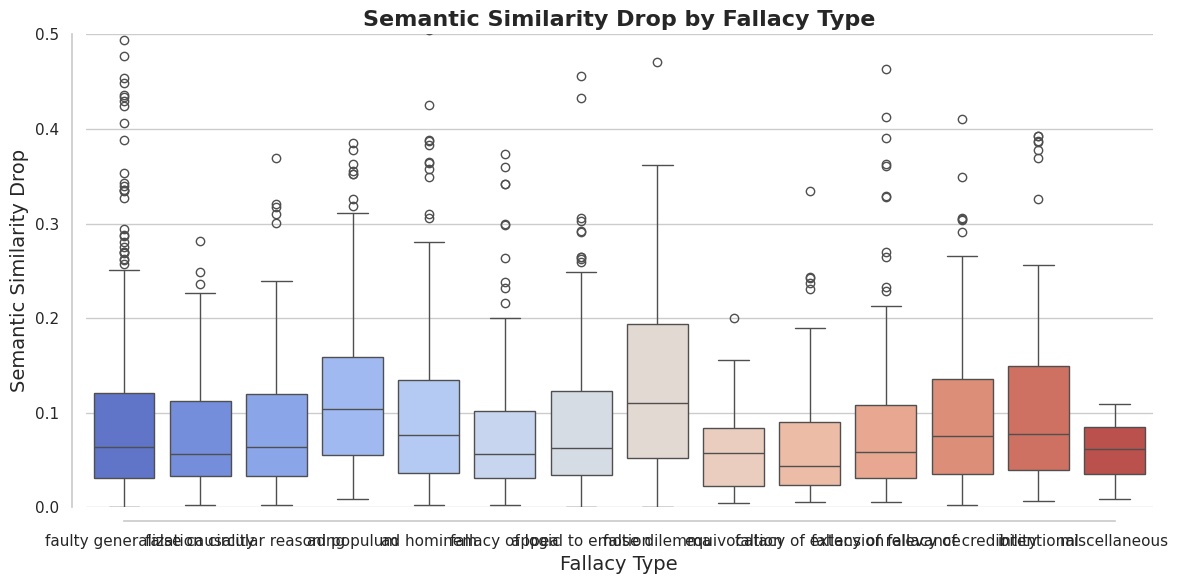

In [ ]:
# Customized Boxplot for Comparing Fallacies
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='fallacy', y='similarity_drop', palette="coolwarm")
plt.title('Semantic Similarity Drop by Fallacy Type', fontsize=16, fontweight='bold')
plt.xlabel('Fallacy Type', fontsize=14)
plt.ylabel('Semantic Similarity Drop', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)  # Focusing on a specific range for more detail
sns.despine(offset=10, trim=True)  # Trimming and offsetting the spines for a cleaner look
plt.tight_layout()
plt.show()


<ipython-input-17-e20f858fa0c4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='fallacy', y='similarity_drop', palette="light:#5A9", showfliers=False)


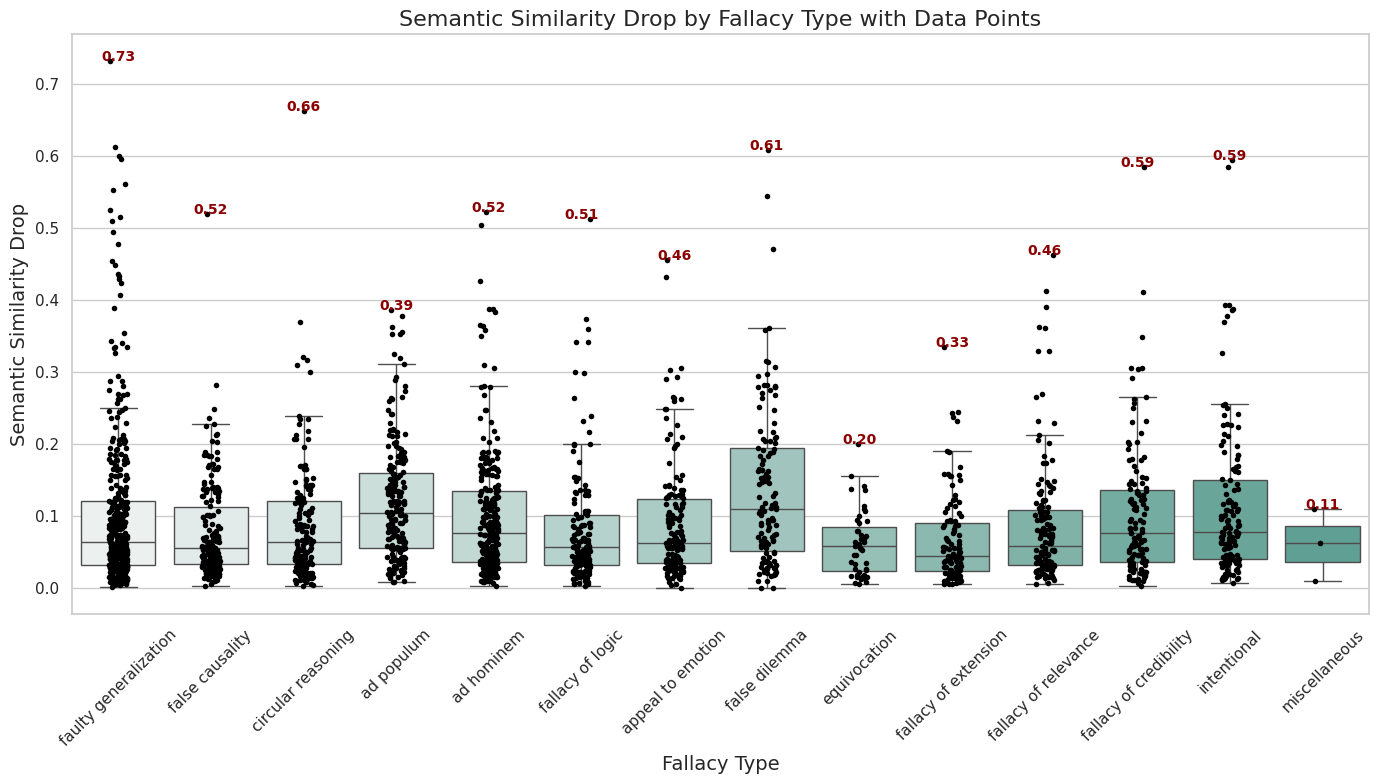

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting style
sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))

# Create a boxplot
sns.boxplot(data=results_df, x='fallacy', y='similarity_drop', palette="light:#5A9", showfliers=False)

# Overlay with stripplot showing all data points
sns.stripplot(data=results_df, x='fallacy', y='similarity_drop', color='black', size=4, jitter=True)

# Improve the aesthetics and legibility
plt.title('Semantic Similarity Drop by Fallacy Type with Data Points', fontsize=16)
plt.xlabel('Fallacy Type', fontsize=14)
plt.ylabel('Semantic Similarity Drop', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better legibility

# Annotating some data points for illustration (showing labels for maximum drops as an example)
for fallacy in results_df['fallacy'].unique():
    # Filtering the dataframe for each fallacy type
    subset = results_df[results_df['fallacy'] == fallacy]

    # Finding the point(s) with maximum drop
    max_drop = subset['similarity_drop'].max()
    max_drop_points = subset[subset['similarity_drop'] == max_drop]

    # Annotate (Due to overlapping, consider annotating a representative or the first point)
    for _, point in max_drop_points.iterrows():
        plt.text(point['fallacy'], point['similarity_drop'], f"{point['similarity_drop']:.2f}",
                 horizontalalignment='center', size='small', color='darkred', weight='semibold')

plt.tight_layout()
plt.show()


In [ ]:
# List of longer, normal random sentences


sentences = [
    "The team of researchers announced a breakthrough in cancer treatment, offering hope to millions of patients around the world.",
    "Archaeologists unearthed an ancient tomb in Egypt, revealing artifacts that date back over 3,000 years and shedding light on early civilization.",
    "The construction of the new highway has been delayed due to environmental concerns, with activists highlighting the impact on local wildlife habitats.",
    "Advances in artificial intelligence are transforming industries, automating tasks that were previously thought to require human intuition and creativity.",
    "The global economy faces unprecedented challenges as nations struggle to balance health priorities with the need to stimulate growth amidst the pandemic.",
    "Environmental scientists warn of the urgent need to reduce carbon emissions, emphasizing renewable energy as a key factor in combating climate change.",
    "The film festival celebrated independent filmmakers, showcasing stories that explore complex social issues through the lens of diverse cultures.",
    "Astronomers discovered a new exoplanet in the habitable zone of a distant star, sparking discussions about the possibilities of life beyond Earth.",
    "The government's digital transformation initiative aims to streamline public services, making them more accessible to citizens through online platforms.",
    "Historians debate the impact of the printing press on the spread of knowledge in the 15th century, marking it as a turning point in human history.",
    "The rise of social media has dramatically changed the landscape of political communication, enabling politicians to engage directly with the electorate.",
    "Public health officials emphasize the importance of vaccinations in preventing outbreaks of diseases that were once thought to be eradicated.",
    "The latest smartphone models feature advanced security technologies, including biometric authentication methods such as fingerprint and facial recognition.",
    "Urban planners are exploring sustainable city designs that incorporate green spaces, aiming to improve residents' well-being and reduce pollution.",
    "The museum's new exhibit features contemporary art that challenges traditional boundaries, inviting visitors to interpret the pieces through an interactive experience.",
    "The novel explores themes of identity and belonging, set against the backdrop of historical events that have shaped the characters' lives.",
    "Innovations in farming technology are revolutionizing agriculture, enabling farmers to increase yields while minimizing environmental impact.",
    "The debate competition brought together students from across the country, encouraging them to articulate their viewpoints on pressing global issues.",
    "Researchers in Antarctica are studying the effects of climate change on polar ice caps, using satellite data to track melting patterns over time.",
    "The conference on renewable energy sources highlighted the latest developments in solar and wind power, drawing attention to successful implementation projects."
]




In [ ]:
def calculate_similarity_drop(sentence):
    # Tokenize and check length
    tokens = tokenizer.tokenize(sentence)
    if len(tokens) > tokenizer.model_max_length:
        tokens = tokens[:tokenizer.model_max_length]

    # Original sentence embedding
    original_embedding = model.encode(sentence, convert_to_tensor=True).cpu().numpy()

    max_drop = 0
    for i, _ in enumerate(tokens):
        # Skip special tokens
        if tokens[i] in [tokenizer.sep_token, tokenizer.cls_token]:
            continue

        # Mask one token at a time
        masked_tokens = tokens.copy()
        masked_tokens[i] = tokenizer.mask_token
        masked_sentence = tokenizer.convert_tokens_to_string(masked_tokens)

        # Generate text with MLM
        try:
            filled_sentence = mlm_pipeline(masked_sentence)[0]['sequence']
        except Exception as e:
            print(e)
            continue

        # Calculate similarity
        filled_embedding = model.encode(filled_sentence, convert_to_tensor=True).cpu().numpy()
        similarity = cosine_similarity([original_embedding], [filled_embedding])[0][0]
        drop = 1 - similarity
        max_drop = max(max_drop, drop)

    return max_drop

In [ ]:
model_name = "bert-base-nli-mean-tokens"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = SentenceTransformer(model_name)
mlm_pipeline = pipeline('fill-mask', model="bert-base-uncased", tokenizer=tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
results_nonf = []  # Initialize the results list

with torch.no_grad():  # Reduces memory usage since gradients aren't needed
    for sentence in sentences:
        try:
            drop = calculate_similarity_drop(sentence)
            results_nonf.append({'sentence': sentence, 'similarity_drop': drop})
        except RuntimeError as e:
            print(f"Skipping sentence due to error: {e}")
            torch.cuda.empty_cache()  # Attempt to free up some memory

# Ensure this list is converted into a DataFrame correctly
df_results_nonf = pd.DataFrame(results_nonf)


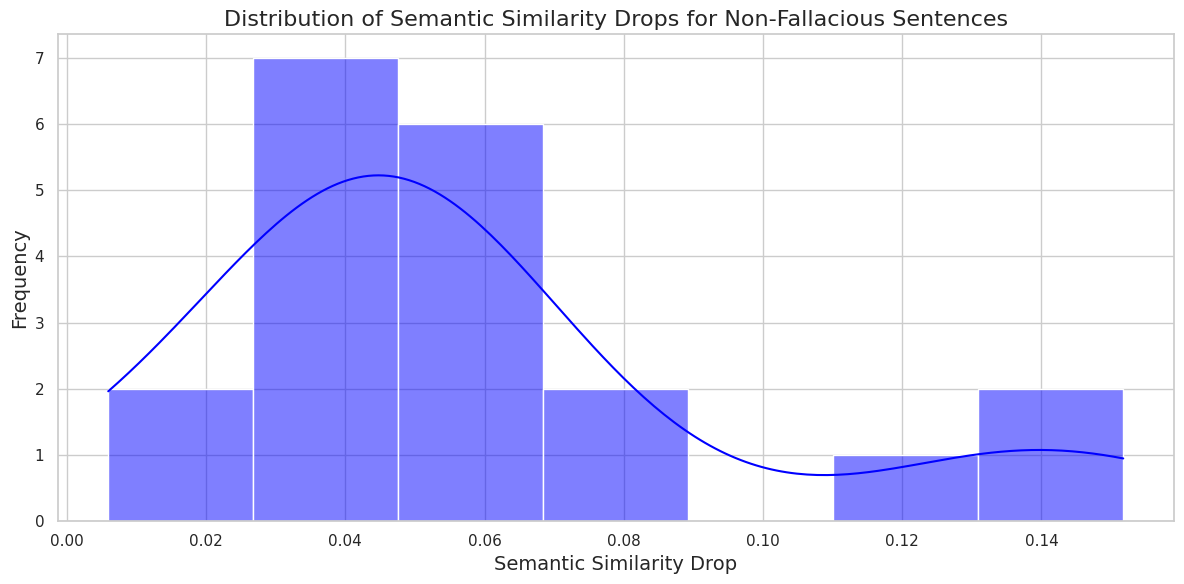

In [ ]:
# Ensure df_results_nonf is created from results_nonf correctly
df_results_nonf = pd.DataFrame(results_nonf)

# Visualization with Seaborn and Matplotlib
sns.set(style="whitegrid")  # Set the style for the plots
plt.figure(figsize=(12, 6))  # Define the figure size

# Correcting data parameter to use DataFrame
sns.histplot(data=df_results_nonf, x='similarity_drop', kde=True, binwidth=0.02, color="blue")

plt.title('Distribution of Semantic Similarity Drops for Non-Fallacious Sentences', fontsize=16)  # Title
plt.xlabel('Semantic Similarity Drop', fontsize=14)  # X-axis label
plt.ylabel('Frequency', fontsize=14)  # Y-axis label

plt.tight_layout()  # Adjust layout to make room for the elements
plt.show()  # Display the plot



In [ ]:
# Assuming results_nonf is populated with your results
df_results_nonf = pd.DataFrame(results_nonf)  # Convert to DataFrame

mean_drop = df_results_nonf['similarity_drop'].mean()
median_drop = df_results_nonf['similarity_drop'].median()
std_drop = df_results_nonf['similarity_drop'].std()

print(f"Mean Semantic Similarity Drop: {mean_drop:.4f}")
print(f"Median Semantic Similarity Drop: {median_drop:.4f}")
print(f"Standard Deviation of Semantic Similarity Drop: {std_drop:.4f}")


Mean Semantic Similarity Drop: 0.0578
Median Semantic Similarity Drop: 0.0480
Standard Deviation of Semantic Similarity Drop: 0.0392


In [ ]:
# Calculating statistics for fallacious sentences
mean_similarity_drop_fallacious = results_df['similarity_drop'].mean()
median_similarity_drop_fallacious = results_df['similarity_drop'].median()
std_similarity_drop_fallacious = results_df['similarity_drop'].std()

# Displaying the calculated statistics for fallacious sentences
print("Statistics for Fallacious Sentences:")
print(f"Mean Semantic Similarity Drop: {mean_similarity_drop_fallacious:.4f}")
print(f"Median Semantic Similarity Drop: {median_similarity_drop_fallacious:.4f}")
print(f"Standard Deviation of Semantic Similarity Drop: {std_similarity_drop_fallacious:.4f}")


Statistics for Fallacious Sentences:
Mean Semantic Similarity Drop: 0.0975
Median Semantic Similarity Drop: 0.0672
Standard Deviation of Semantic Similarity Drop: 0.0932
